<a href="https://colab.research.google.com/github/ashish807/Stanford-Sentiment-Treebank-/blob/main/Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


In [4]:
######################################################
#
# SST dataset, the sentences are encoded with latin1,
# and the rest is in utf-8. You have to decode and 
# encode properly to construct the dataset.
#
######################################################


#!/usr/bin/env python
# -*- coding: utf-8 -*-
import os, re, copy, itertools
import pandas as pd
import numpy as np
import csv
import bs4 as bs
from unicodedata import normalize
from functools import partial


#################
#
# id to rating
#
#################
sentence_rr = []
sentence_id = dict()
sentence_file = "/content/drive/My Drive/stanfordSentimentTreebank/datasetSentences.txt"
f = open(sentence_file, "r")
head = True
for x in f:
	if head:
		head = False
		continue
	s_p = " ".join([t.encode('latin1').decode('utf-8').lower() for t in x.split("\t")[-1].strip().split(" ")])
	sentence_rr.append(s_p)
	# this is to prevent collisions
	if s_p in sentence_id.keys():
		sentence_id[s_p].append(int(x.split("\t")[0]))
	else:
		sentence_id[s_p] = [int(x.split("\t")[0])]
print("Finish loading sentences ...")
# Load phrase mapping
phrase = dict()
phrase_file = "/content/drive/My Drive/stanfordSentimentTreebank/dictionary.txt"
f = open(phrase_file, "r")
for x in f:
	seq = " ".join([t.lower() for t in x.split("|")[0].strip().split(" ")])
	phrase_id = int(x.split("|")[1])
	phrase[seq] = phrase_id
# Load phrase rate mapping
phrase_rate = dict()
phrase_rate_file = "/content/drive/My Drive/stanfordSentimentTreebank/sentiment_labels.txt"
f = open(phrase_rate_file, "r")
head = True
for x in f:
	if head:
		head = False
		continue
	p_id = int(x.split("|")[0])
	rr = float(x.split("|")[1])
	phrase_rate[p_id] = rr
# Loading sentence to phrase id mapping
sentence_rate = dict()
count = 0
miss_count = 0

# have a separate count matrics to avoid collisions
sentence_count = dict()
for seq in sentence_rr:
	sentence_count[seq] = 0

for seq in sentence_rr:
	if seq not in phrase.keys():
		# it menas it contain tokenized parenthese
		seq_l = re.sub("-lrb-", "(", seq)
		seq_lr = re.sub("-rrb-", ")", seq_l)
		sentence_rate[sentence_id[seq][0]] = phrase_rate[phrase[seq_lr]] # no collision
		if seq_lr not in phrase.keys():
			assert(False)
	else:
		sentence_rate[sentence_id[seq][sentence_count[seq]]] = phrase_rate[phrase[seq]]
		sentence_count[seq] = sentence_count[seq] + 1

#################
#
# id to partition
#
#################
# Load partition info
partition = dict()
partition['Train'] = []
partition['Test'] = []
partition['Valid'] = []
partition_file = "/content/drive/My Drive/stanfordSentimentTreebank/datasetSplit.txt"
f = open(partition_file, "r")
head = True
for x in f:
	if head:
		head = False
		continue
	p = int(x.split(",")[1])
	fi = int(x.split(",")[0])
	if p == 1:
		partition['Train'].append(fi)
	elif p == 2:
		partition['Test'].append(fi)
	elif p == 3:
		partition['Valid'].append(fi)
print("Finish loading partition ...")


#################
#
# id to embeddings
#
#################
# Load tokens
token_file = "/content/drive/My Drive/stanfordSentimentTreebank/glove/dict.txt"
token_list = []
f = open(token_file, "r")
for x in f:
	token_list += [x.strip()]
print("Finish loading tokens ...")
# Load embeddings for those tokens
glove_file = "/content/drive/My Drive/stanfordSentimentTreebank/glove/sentiment_glove_300.txt"
token_glove = dict()
f = open(glove_file, "r")
index = 0
for x in f:
	token_glove[token_list[index]] = \
		[float(dim) for dim in x.split(" ")]
	index += 1
print("Finish loading glove dictionary ...")
# Load sentences
sentence = dict()
sentence_file = "/content/drive/My Drive/stanfordSentimentTreebank/datasetSentences.txt"
f = open(sentence_file, "r")
head = True
for x in f:
	if head:
		head = False
		continue
	sentence[int(x.split("\t")[0])] = [t.encode('latin1').decode('utf-8').lower() for t in x.split("\t")[-1].strip().split(" ")]
print("Finish loading sentences ...")
# embedding and sentence
na_vec = 300 * [0.0]
header = ['word']
header.extend(['glove'+str(i) for i in range(300)])
sentence_id_embed = dict()
for seq in sentence.keys():
	# print("Creating feature files for sentence id: " + str(seq) + " ...")
	sentence_id_embed[seq] = []
	for token in sentence[seq]:
		if token not in token_list:
			# we should not have any words in here
			assert(True)
		else:
			sentence_id_embed[seq].append(token_glove[token])


#################
#
# save
#
#################
import pickle

pickle.dump( sentence, open("id_sentence.p", "wb") )

# partition - rating and embedding
train_final = []
val_final = []
test_final = []
for sss in sentence_rate.keys():
	if sss in partition['Train']:
		train_final.append(sss)
	elif sss in partition['Valid']:
		val_final.append(sss)
	elif sss in partition['Test']:
		test_final.append(sss)

train_embed = dict()
train_rr = dict()
for sss in train_final:
	train_embed[sss] = sentence_id_embed[sss]
	train_rr[sss] = sentence_rate[sss]
pickle.dump( train_embed, open("id_embed_train.p", "wb") )
pickle.dump( train_rr, open("id_rating_train.p", "wb") )

valid_embed = dict()
valid_rr = dict()
for sss in val_final:
	valid_embed[sss] = sentence_id_embed[sss]
	valid_rr[sss] = sentence_rate[sss]
pickle.dump( valid_embed, open("id_embed_valid.p", "wb") )
pickle.dump( valid_rr, open("id_rating_valid.p", "wb") )

test_embed = dict()
test_rr = dict()
for sss in test_final:
	test_embed[sss] = sentence_id_embed[sss]
	test_rr[sss] = sentence_rate[sss]
pickle.dump( test_embed, open("id_embed_test.p", "wb") )
pickle.dump( test_rr, open("id_rating_test.p", "wb"))
import pickle
id_embed_train = pickle.load( open( "id_embed_train.p", "rb" ) )
#print(id_embed_train.keys()) # 11853, 11854, 11855
print(len(id_embed_train[11855]))
print(len(id_embed_train[11853]))
id_sentence = pickle.load( open( "id_sentence.p", "rb" ) )
print(id_sentence[11855])
print(id_sentence[11854])

Finish loading sentences ...
Finish loading partition ...
Finish loading tokens ...
Finish loading glove dictionary ...
Finish loading sentences ...
5
23
['in', 'this', 'case', 'zero', '.']
['her', 'fans', 'walked', 'out', 'muttering', 'words', 'like', '``', 'horrible', "''", 'and', '``', 'terrible', ',', "''", 'but', 'had', 'so', 'much', 'fun', 'dissing', 'the', 'film', 'that', 'they', 'did', "n't", 'mind', 'the', 'ticket', 'cost', '.']


In [5]:

from tensorflow.keras.preprocessing.sequence import pad_sequences 

In [6]:
id_rating_train = pickle.load( open( "id_rating_train.p", "rb" ) )
print(len(id_rating_train))
print(id_rating_train[11854])


8544
0.13889


In [7]:
y_train =[]
y_train_index = []
for i in id_rating_train:
  y_train_index.append(i)
  if id_rating_train[i] >= 0 and id_rating_train[i] <= 0.2:
    y_train.append(0)
  if id_rating_train[i] > 0.2 and id_rating_train[i] <= 0.4:
    y_train.append(1)
  if id_rating_train[i] > 0.4 and id_rating_train[i] <= 0.6:
    y_train.append(2)
  if id_rating_train[i] > 0.6 and id_rating_train[i] <= 0.8:
    y_train.append(3)
  if id_rating_train[i] > 0.8 and id_rating_train[i] <= 1:
    y_train.append(4)



In [8]:
len(y_train_index)

8544

In [9]:
count =0
for i in id_rating_train:
  
  count+=1
print(count)  

8544


In [10]:
y_train =np.array(y_train)
y_train


array([3, 4, 3, ..., 3, 0, 1])

In [11]:
id_rating_valid = pickle.load( open( "id_rating_valid.p", "rb" ) )

y_valid_index =[]
y_valid =[]
for i in id_rating_valid:
  y_valid_index.append(i)
  if id_rating_valid[i] >= 0 and id_rating_valid[i] <= 0.2:
    y_valid.append(0)
  if id_rating_valid[i] > 0.2 and id_rating_valid[i] <= 0.4:
    y_valid.append(1)
  if id_rating_valid[i] > 0.4 and id_rating_valid[i] <= 0.6:
    y_valid.append(2)
  if id_rating_valid[i] > 0.6 and id_rating_valid[i] <= 0.8:
    y_valid.append(3)
  if id_rating_valid[i] > 0.8 and id_rating_valid[i] <= 1:
    y_valid.append(4)


In [12]:
len(y_valid)
y_valid =np.array(y_valid)
len(y_valid_index)


1101

In [13]:
id_rating_test = pickle.load( open( "id_rating_test.p", "rb" ) )

y_test_index=[]
y_test =[]
for i in id_rating_test:
  y_test_index.append(i)
  if id_rating_test[i] >= 0 and id_rating_test[i] <= 0.2:
    y_test.append(0)
  if id_rating_test[i] > 0.2 and id_rating_test[i] <= 0.4:
    y_test.append(1)
  if id_rating_test[i] > 0.4 and id_rating_test[i] <= 0.6:
    y_test.append(2)
  if id_rating_test[i] > 0.6 and id_rating_test[i] <= 0.8:
    y_test.append(3)
  if id_rating_test[i] > 0.8 and id_rating_test[i] <= 1:
    y_test.append(4)

In [14]:
len(y_test)
y_test =np.array(y_test)
len(y_test_index)


2210

In [15]:
id_sentence = pickle.load( open( "id_sentence.p", "rb" ) )
print(id_sentence[5159])
print(id_sentence[11854])

['the', 'piano', 'teacher', 'is', 'not', 'an', 'easy', 'film', '.']
['her', 'fans', 'walked', 'out', 'muttering', 'words', 'like', '``', 'horrible', "''", 'and', '``', 'terrible', ',', "''", 'but', 'had', 'so', 'much', 'fun', 'dissing', 'the', 'film', 'that', 'they', 'did', "n't", 'mind', 'the', 'ticket', 'cost', '.']


In [16]:
sentences_train = []
sentences_valid=[]
sentences_test = []

for i in id_sentence:
  tes =[]
  tes.append(" ".join(str(el) for el in id_sentence[i]))
  if i in y_train_index:
    sentences_train.extend(tes)
  if i in y_valid_index:
    sentences_valid.extend(tes)
  if i in y_test_index:
    sentences_test.extend(tes)


  


In [17]:
import pandas as pd
dataframe_train = pd.DataFrame(y_train_index, columns =["Index"])
dataframe_train["Sentences"] =  sentences_train
dataframe_train["Sentiments_Value"] = y_train

In [18]:
dataframe_train

,Index,Sentences,Sentiments_Value
0,1,the rock is destined to be the 21st century 's...,3
1,2,the gorgeously elaborate continuation of `` th...,4
2,61,singer\/composer bryan adams contributes a sle...,3
3,62,you 'd think by now america would have had eno...,2
4,63,yet the act is still charming here .,3
...,...,...,...
8539,11851,a real snooze .,0
8540,11852,no surprises .,1
8541,11853,we 've seen the hippie-turned-yuppie plot befo...,3
8542,11854,her fans walked out muttering words like `` ho...,0


In [19]:
dataframe_valid = pd.DataFrame(y_valid_index, columns =["Index"])
dataframe_valid["Sentences"] =  sentences_valid
dataframe_valid["Sentiments_Value"] = y_valid
dataframe_valid

,Index,Sentences,Sentiments_Value
0,1117,it 's a lovely film with lovely performances b...,3
1,1118,"no one goes unindicted here , which is probabl...",2
2,1119,and if you 're not nearly moved to tears by a ...,3
3,1120,"a warm , funny , engaging film .",4
4,1121,uses sharp humor and insight into human nature...,4
...,...,...,...
1096,7901,it seems to me the film is about the art of ri...,1
1097,7902,it 's just disappointingly superficial -- a mo...,1
1098,7903,the title not only describes its main characte...,1
1099,7904,sometimes it feels as if it might have been ma...,2


In [20]:
dataframe_test = pd.DataFrame(y_test_index, columns =["Index"])
dataframe_test["Sentences"] =  sentences_test
dataframe_test["Sentiments_Value"] = y_test
dataframe_test

,Index,Sentences,Sentiments_Value
0,3,effective but too-tepid biopic,2
1,4,if you sometimes like to go to the movies to h...,3
2,5,"emerges as something rare , an issue movie tha...",4
3,6,the film provides some great insight into the ...,2
4,7,offers that rare combination of entertainment ...,4
...,...,...,...
2205,11621,an imaginative comedy\/thriller .,3
2206,11623,"-lrb- a -rrb- rare , beautiful film .",4
2207,11626,-lrb- an -rrb- hilarious romantic comedy .,4
2208,11628,never -lrb- sinks -rrb- into exploitation .,3


In [21]:
def remove_pattern(input_txt, pattern):
  r = re.findall(pattern, input_txt)
  for i in r:
    input_txt = re.sub(i, '', input_txt)
  return input_txt

dataframe_train["SentenceFormated"] = np.vectorize(remove_pattern)(dataframe_train['Sentences'], "@[\w]*")

dataframe_train['SentenceFormated'] = dataframe_train['SentenceFormated'].str.replace('[^a-zA-Z#]!+', ' ')
dataframe_train["SentenceFormated"] = dataframe_train["SentenceFormated"].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))


In [22]:

dataframe_valid["SentenceFormated"] = np.vectorize(remove_pattern)(dataframe_valid['Sentences'], "@[\w]*")

dataframe_valid['SentenceFormated'] = dataframe_valid['SentenceFormated'].str.replace('[^a-zA-Z#]!+', ' ')
dataframe_valid["SentenceFormated"] = dataframe_valid["SentenceFormated"].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
dataframe_valid
dataframe_train["SentenceFormated"] = np.vectorize(remove_pattern)(dataframe_train['Sentences'], "@[\w]*")

dataframe_train['SentenceFormated'] = dataframe_train['SentenceFormated'].str.replace('[^a-zA-Z#]!+', ' ')
dataframe_train["SentenceFormated"] = dataframe_train["SentenceFormated"].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [23]:

dataframe_test["SentenceFormated"] = np.vectorize(remove_pattern)(dataframe_test['Sentences'], "@[\w]*")

dataframe_test['SentenceFormated'] = dataframe_test['SentenceFormated'].str.replace('[^a-zA-Z#]!+', ' ')
dataframe_test["SentenceFormated"] = dataframe_test["SentenceFormated"].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
dataframe_test

,Index,Sentences,Sentiments_Value,SentenceFormated
0,3,effective but too-tepid biopic,2,effective too-tepid biopic
1,4,if you sometimes like to go to the movies to h...,3,sometimes like movies have wasabi good place s...
2,5,"emerges as something rare , an issue movie tha...",4,emerges something rare issue movie that honest...
3,6,the film provides some great insight into the ...,2,film provides some great insight into neurotic...
4,7,offers that rare combination of entertainment ...,4,offers that rare combination entertainment edu...
...,...,...,...,...
2205,11621,an imaginative comedy\/thriller .,3,imaginative comedy\/thriller
2206,11623,"-lrb- a -rrb- rare , beautiful film .",4,-lrb- -rrb- rare beautiful film
2207,11626,-lrb- an -rrb- hilarious romantic comedy .,4,-lrb- -rrb- hilarious romantic comedy
2208,11628,never -lrb- sinks -rrb- into exploitation .,3,never -lrb- sinks -rrb- into exploitation


In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
import tensorflow as tf

In [25]:
tokenized_sent_train = dataframe_train['SentenceFormated'].apply(lambda x: x.split())

In [26]:
tokenized_sent_valid = dataframe_valid['SentenceFormated'].apply(lambda x: x.split())
tokenized_sent_valid

0       [lovely, film, with, lovely, performances, acc...
1         [goes, unindicted, here, which, probably, best]
2       [nearly, moved, tears, couple, scenes, water, ...
3                           [warm, funny, engaging, film]
4       [uses, sharp, humor, insight, into, human, nat...
                              ...                        
1096    [seems, film, about, ripping, people, without,...
1097    [just, disappointingly, superficial, movie, th...
1098    [title, only, describes, main, characters, laz...
1099    [sometimes, feels, might, have, been, made, '7...
1100    [schaeffer, find, some, hook, which, hang, per...
Name: SentenceFormated, Length: 1101, dtype: object

In [27]:
tokenized_sent_test = dataframe_test['SentenceFormated'].apply(lambda x: x.split())
tokenized_sent_test

0                          [effective, too-tepid, biopic]
1       [sometimes, like, movies, have, wasabi, good, ...
2       [emerges, something, rare, issue, movie, that,...
3       [film, provides, some, great, insight, into, n...
4       [offers, that, rare, combination, entertainmen...
                              ...                        
2205                      [imaginative, comedy\/thriller]
2206                [-lrb-, -rrb-, rare, beautiful, film]
2207          [-lrb-, -rrb-, hilarious, romantic, comedy]
2208     [never, -lrb-, sinks, -rrb-, into, exploitation]
2209                 [-lrb-, -rrb-, nrelentingly, stupid]
Name: SentenceFormated, Length: 2210, dtype: object

In [28]:
tokenized_sent_train

0       [rock, destined, 21st, century, conan, that, g...
1       [gorgeously, elaborate, continuation, lord, ri...
2       [singer\/composer, bryan, adams, contributes, ...
3       [think, america, would, have, enough, plucky, ...
4                                 [still, charming, here]
                              ...                        
8539                                       [real, snooze]
8540                                          [surprises]
8541    [seen, hippie-turned-yuppie, plot, before, the...
8542    [fans, walked, muttering, words, like, horribl...
8543                                   [this, case, zero]
Name: SentenceFormated, Length: 8544, dtype: object

In [29]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_sent_train= tokenized_sent_train.apply(lambda x: [stemmer.stem(i) for i in x])

In [30]:
tokenized_sent_valid= tokenized_sent_valid.apply(lambda x: [stemmer.stem(i) for i in x])
tokenized_sent_valid

0              [love, film, with, love, perform, accorsi]
1             [goe, unindict, here, which, probabl, best]
2       [nearli, move, tear, coupl, scene, water, your...
3                              [warm, funni, engag, film]
4       [use, sharp, humor, insight, into, human, natu...
                              ...                        
1096    [seem, film, about, rip, peopl, without, ever,...
1097    [just, disappointingli, superfici, movi, that,...
1098    [titl, onli, describ, main, charact, lazi, peo...
1099    [sometim, feel, might, have, been, made, '70, ...
1100    [schaeffer, find, some, hook, which, hang, per...
Name: SentenceFormated, Length: 1101, dtype: object

In [31]:
tokenized_sent_test= tokenized_sent_test.apply(lambda x: [stemmer.stem(i) for i in x])
tokenized_sent_test

0                             [effect, too-tepid, biopic]
1       [sometim, like, movi, have, wasabi, good, plac...
2       [emerg, someth, rare, issu, movi, that, honest...
3       [film, provid, some, great, insight, into, neu...
4            [offer, that, rare, combin, entertain, educ]
                              ...                        
2205                              [imagin, comedy\/thril]
2206                   [-lrb-, -rrb-, rare, beauti, film]
2207               [-lrb-, -rrb-, hilari, romant, comedi]
2208           [never, -lrb-, sink, -rrb-, into, exploit]
2209                 [-lrb-, -rrb-, nrelentingli, stupid]
Name: SentenceFormated, Length: 2210, dtype: object

In [32]:
tokenized_sent_train

0       [rock, destin, 21st, centuri, conan, that, go,...
1       [gorgeous, elabor, continu, lord, ring, trilog...
2       [singer\/compos, bryan, adam, contribut, slew,...
3       [think, america, would, have, enough, plucki, ...
4                                    [still, charm, here]
                              ...                        
8539                                        [real, snooz]
8540                                            [surpris]
8541    [seen, hippie-turned-yuppi, plot, befor, there...
8542    [fan, walk, mutter, word, like, horribl, terri...
8543                                    [thi, case, zero]
Name: SentenceFormated, Length: 8544, dtype: object

In [33]:
for i in range(len(tokenized_sent_train)):
  tokenized_sent_train[i] = ' '.join(tokenized_sent_train[i])
tokenized_sent_train

0       rock destin 21st centuri conan that go make sp...
1       gorgeous elabor continu lord ring trilog huge ...
2       singer\/compos bryan adam contribut slew song ...
3       think america would have enough plucki british...
4                                        still charm here
                              ...                        
8539                                           real snooz
8540                                              surpris
8541    seen hippie-turned-yuppi plot befor there enth...
8542    fan walk mutter word like horribl terribl much...
8543                                        thi case zero
Name: SentenceFormated, Length: 8544, dtype: object

In [34]:
for i in range(len(tokenized_sent_valid)):
  tokenized_sent_valid[i] = ' '.join(tokenized_sent_valid[i])
tokenized_sent_valid

0                     love film with love perform accorsi
1                    goe unindict here which probabl best
2            nearli move tear coupl scene water your vein
3                                   warm funni engag film
4       use sharp humor insight into human natur exami...
                              ...                        
1096    seem film about rip peopl without ever let the...
1097    just disappointingli superfici movi that eleme...
1098    titl onli describ main charact lazi peopl behi...
1099    sometim feel might have been made '70 '80 star...
1100    schaeffer find some hook which hang persist us...
Name: SentenceFormated, Length: 1101, dtype: object

In [35]:
for i in range(len(tokenized_sent_test)):
  tokenized_sent_test[i] = ' '.join(tokenized_sent_test[i])
tokenized_sent_test

0                                 effect too-tepid biopic
1          sometim like movi have wasabi good place start
2       emerg someth rare issu movi that honest keenli...
3       film provid some great insight into neurot min...
4                   offer that rare combin entertain educ
                              ...                        
2205                                 imagin comedy\/thril
2206                         -lrb- -rrb- rare beauti film
2207                     -lrb- -rrb- hilari romant comedi
2208                  never -lrb- sink -rrb- into exploit
2209                      -lrb- -rrb- nrelentingli stupid
Name: SentenceFormated, Length: 2210, dtype: object

In [36]:
dataframe_train["SentenceFormated"] = tokenized_sent_train

In [37]:
dataframe_train

,Index,Sentences,Sentiments_Value,SentenceFormated
0,1,the rock is destined to be the 21st century 's...,3,rock destin 21st centuri conan that go make sp...
1,2,the gorgeously elaborate continuation of `` th...,4,gorgeous elabor continu lord ring trilog huge ...
2,61,singer\/composer bryan adams contributes a sle...,3,singer\/compos bryan adam contribut slew song ...
3,62,you 'd think by now america would have had eno...,2,think america would have enough plucki british...
4,63,yet the act is still charming here .,3,still charm here
...,...,...,...,...
8539,11851,a real snooze .,0,real snooz
8540,11852,no surprises .,1,surpris
8541,11853,we 've seen the hippie-turned-yuppie plot befo...,3,seen hippie-turned-yuppi plot befor there enth...
8542,11854,her fans walked out muttering words like `` ho...,0,fan walk mutter word like horribl terribl much...


In [38]:
dataframe_valid["SentenceFormated"] = tokenized_sent_valid
dataframe_valid

,Index,Sentences,Sentiments_Value,SentenceFormated
0,1117,it 's a lovely film with lovely performances b...,3,love film with love perform accorsi
1,1118,"no one goes unindicted here , which is probabl...",2,goe unindict here which probabl best
2,1119,and if you 're not nearly moved to tears by a ...,3,nearli move tear coupl scene water your vein
3,1120,"a warm , funny , engaging film .",4,warm funni engag film
4,1121,uses sharp humor and insight into human nature...,4,use sharp humor insight into human natur exami...
...,...,...,...,...
1096,7901,it seems to me the film is about the art of ri...,1,seem film about rip peopl without ever let the...
1097,7902,it 's just disappointingly superficial -- a mo...,1,just disappointingli superfici movi that eleme...
1098,7903,the title not only describes its main characte...,1,titl onli describ main charact lazi peopl behi...
1099,7904,sometimes it feels as if it might have been ma...,2,sometim feel might have been made '70 '80 star...


In [39]:
dataframe_test["SentenceFormated"] = tokenized_sent_test

In [40]:
dataframe_test

,Index,Sentences,Sentiments_Value,SentenceFormated
0,3,effective but too-tepid biopic,2,effect too-tepid biopic
1,4,if you sometimes like to go to the movies to h...,3,sometim like movi have wasabi good place start
2,5,"emerges as something rare , an issue movie tha...",4,emerg someth rare issu movi that honest keenli...
3,6,the film provides some great insight into the ...,2,film provid some great insight into neurot min...
4,7,offers that rare combination of entertainment ...,4,offer that rare combin entertain educ
...,...,...,...,...
2205,11621,an imaginative comedy\/thriller .,3,imagin comedy\/thril
2206,11623,"-lrb- a -rrb- rare , beautiful film .",4,-lrb- -rrb- rare beauti film
2207,11626,-lrb- an -rrb- hilarious romantic comedy .,4,-lrb- -rrb- hilari romant comedi
2208,11628,never -lrb- sinks -rrb- into exploitation .,3,never -lrb- sink -rrb- into exploit


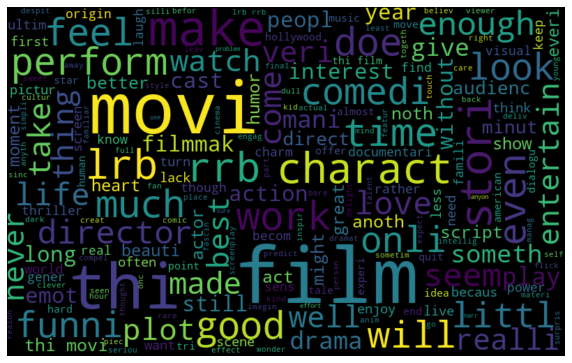

In [41]:
all_words = ' '.join([text for text in dataframe_train['SentenceFormated']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

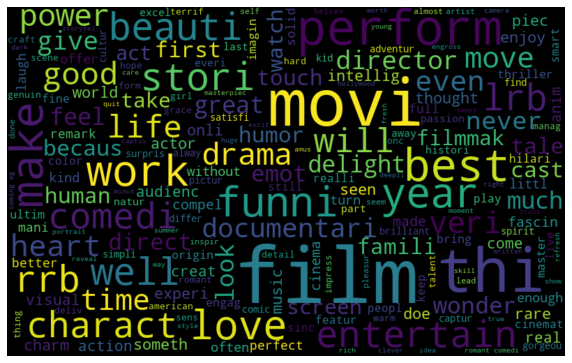

In [42]:
level_5 = " ".join([text for text in dataframe_train["SentenceFormated"][dataframe_train["Sentiments_Value"]==4]])

wordcloud = WordCloud(width =800, height=500, random_state=21, max_font_size=110).generate(level_5)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


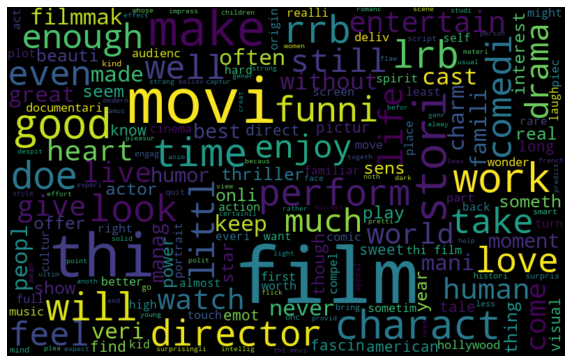

In [43]:
level_4 = " ".join([text for text in dataframe_train["SentenceFormated"][dataframe_train["Sentiments_Value"]==3]])

wordcloud = WordCloud(width =800, height=500, random_state=21, max_font_size=110).generate(level_4)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

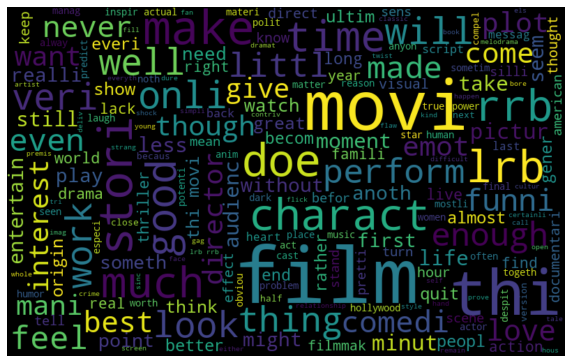

In [44]:
level_3 = " ".join([text for text in dataframe_train["SentenceFormated"][dataframe_train["Sentiments_Value"]==2]])

wordcloud = WordCloud(width =800, height=500, random_state=21, max_font_size=110).generate(level_3)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

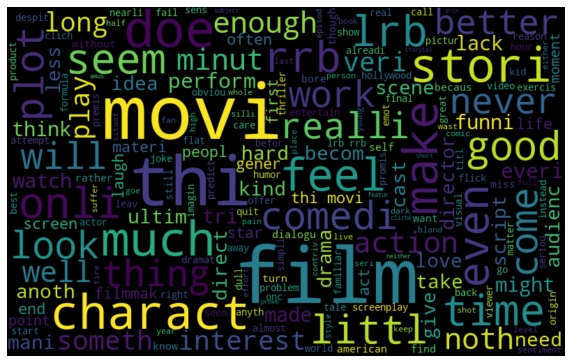

In [45]:
level_2 = " ".join([text for text in dataframe_train["SentenceFormated"][dataframe_train["Sentiments_Value"]==1]])

wordcloud = WordCloud(width =800, height=500, random_state=21, max_font_size=110).generate(level_2)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

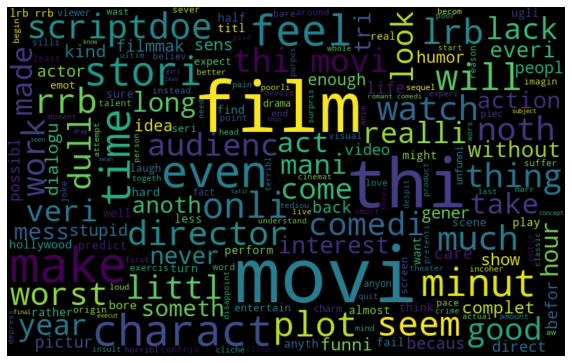

In [46]:
level_1 = " ".join([text for text in dataframe_train["SentenceFormated"][dataframe_train["Sentiments_Value"]==0]])

wordcloud = WordCloud(width =800, height=500, random_state=21, max_font_size=110).generate(level_1)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [47]:
np.array(dataframe_train.Sentiments_Value)

array([3, 4, 3, ..., 3, 0, 1])

In [48]:
final_y_train = tf.one_hot(dataframe_train.Sentiments_Value, axis=1, depth = 5) 
final_y_valid = tf.one_hot(dataframe_valid.Sentiments_Value, axis=1,depth=5)
final_y_test = tf.one_hot(dataframe_test.Sentiments_Value,axis =1, depth=5)
final_y_valid

<tf.Tensor: shape=(1101, 5), dtype=float32, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)>

In [49]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
import tensorflow as tf

In [50]:

X_train_Sent = dataframe_train.SentenceFormated.values
X_dev_Sent = dataframe_valid.SentenceFormated.values
X_test_Sent = dataframe_test.SentenceFormated.values


In [51]:
#For training
max_vocab = 500000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train_Sent)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(X_train_Sent)
padded_sequence = pad_sequences(encoded_docs, maxlen=100)


In [52]:
padded_sequence.shape[1]

100

In [53]:
#For validation
tokenizer_dev = Tokenizer(num_words=max_vocab)
tokenizer_dev.fit_on_texts(X_dev_Sent)
vocab_size_dev = len(tokenizer_dev.word_index) + 1
encoded_docs_dev = tokenizer_dev.texts_to_sequences(X_dev_Sent)
padded_sequence_dev = pad_sequences(encoded_docs_dev, maxlen=100)
padded_sequence_dev

array([[   0,    0,    0, ...,   26,   30, 1631],
       [   0,    0,    0, ...,  111,  321,   41],
       [   0,    0,    0, ...,  485,   80, 1633],
       ...,
       [   0,    0,    0, ...,  966,  361,   29],
       [   0,    0,    0, ...,  905, 1426, 1427],
       [   0,    0,    0, ..., 1599,  527,   10]], dtype=int32)

In [54]:
#For test
tokenizer_test = Tokenizer(num_words=max_vocab)
tokenizer_test.fit_on_texts(X_test_Sent)

vocab_size_test = len(tokenizer_test.word_index) + 1
encoded_docs_test = tokenizer_test.texts_to_sequences(X_test_Sent)
padded_sequence_test = pad_sequences(encoded_docs_test, maxlen=100)
padded_sequence_test

array([[   0,    0,    0, ..., 1726, 1280, 2723],
       [   0,    0,    0, ...,   22,  238,  213],
       [   0,    0,    0, ...,   28,   30,    6],
       ...,
       [   0,    0,    0, ...,  474,  118,   20],
       [   0,    0,    0, ...,   17,   19,  958],
       [   0,    0,    0, ...,   17, 5769,  440]], dtype=int32)

In [55]:
print(tokenizer.word_index)

{'that': 1, 'film': 2, 'movi': 3, 'with': 4, 'thi': 5, 'like': 6, 'about': 7, 'more': 8, 'from': 9, 'have': 10, 'than': 11, 'make': 12, 'stori': 13, 'lrb': 14, 'rrb': 15, 'charact': 16, 'what': 17, 'there': 18, 'time': 19, 'doe': 20, 'good': 21, 'into': 22, 'just': 23, 'most': 24, 'work': 25, 'comedi': 26, 'will': 27, 'even': 28, 'much': 29, 'feel': 30, 'perform': 31, 'director': 32, 'some': 33, 'well': 34, 'look': 35, 'funni': 36, 'their': 37, 'onli': 38, 'love': 39, 'littl': 40, 'your': 41, 'they': 42, 'never': 43, 'would': 44, 'veri': 45, 'been': 46, 'which': 47, 'come': 48, 'enough': 49, 'thing': 50, 'seem': 51, 'life': 52, 'year': 53, 'take': 54, 'best': 55, 'when': 56, 'watch': 57, 'entertain': 58, 'while': 59, 'could': 60, 'plot': 61, 'drama': 62, 'made': 63, 'other': 64, 'through': 65, 'action': 66, 'give': 67, 'someth': 68, 'interest': 69, 'realli': 70, 'audienc': 71, 'mani': 72, 'minut': 73, 'play': 74, 'should': 75, 'cast': 76, 'better': 77, 'those': 78, 'without': 79, 'act'

In [56]:
print(padded_sequence.shape)

(8544, 100)


In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM , Dense , Dropout, Bidirectional
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
embedding_vector_length = 128
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=padded_sequence.shape[1]) )
model.add(SpatialDropout1D(0.25))
model.add(Bidirectional(LSTM(100, return_sequences=True,dropout=0.5, recurrent_dropout=0.5)))
model.add(Bidirectional(LSTM(50, return_sequences=False, recurrent_dropout=0.5)))


model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss="categorical_crossentropy",optimizer='adam', 
                           metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 128)          1380224   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 128)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 200)          183200    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               100400    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 505       
Total params: 1,664,329
Trainable params: 1,664,329
Non-trainable params: 0
______________________________________________

In [58]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
checkpointer = ModelCheckpoint(filepath = "Sentiment.hdf5", verbose = 1, save_best_only=True)

In [64]:
history = model.fit(x=padded_sequence,
                    y=final_y_train,
                    validation_data=(padded_sequence_dev,final_y_valid), 
                    epochs=4, 
                    batch_size=64,
                    callbacks=[checkpointer])

134/134 [==============================] - ETA: 0s - loss: 0.7453 - accuracy: 0.7182
Epoch 00001: val_loss did not improve from 1.76678
134/134 [==============================] - 174s 1s/step - loss: 0.7453 - accuracy: 0.7182 - val_loss: 2.6292 - val_accuracy: 0.2262


OverFit the Train data